In [1]:
from os import listdir
from os.path import isfile, join

import numpy as np
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
import pydicom
import pandas as pd
import seaborn

In [2]:
PATH = "./Data"

files = [f for f in listdir(PATH) if isfile(join(PATH, f))]

def profil(files):
    df = pd.DataFrame()
    parametre = pd.DataFrame([], 
                            index=pd.Index(['kVp', 'mA', 'Largeur pulse']))
    for f in files :
        ds = pydicom.dcmread(PATH+'/'+f)

        image = ds.pixel_array.max()-ds.pixel_array
        name=str(ds[0x08,0x103E].value)+'_'+str(ds[0x18,0x40].value)+'i/s'

        df[name]=np.mean(image[:,380:420],axis=1)
        parametre[name]=[ds[0x18,0x60].value, ds[0x18,0x1151].value, ds[0x18,0x1063].value]

        plt.imshow(image[:,380:420], cmap="gray")
        plt.axis('off')
    
    plt.figure()
    plt.plot(df,label=df.columns)
    plt.legend(bbox_to_anchor=(1.05, 1))

    return df, parametre

def FWHM(data):
    FWHM_data=pd.DataFrame()
    Amplitude_data=pd.DataFrame()
    
    for f in data.columns:
        peaks, _ = find_peaks(data[f], height=data[f].iloc[-1]+1, distance=50)
        prominence = ()
        amplitude_pic = []
        left = []
        right = []
        for p in peaks:
            baseline = np.mean(data[f].values[p-30:p-10])
            # print(data[f].values[p-30:p-10], baseline)
            amplitude_pic.append(data[f].values[p] - baseline)
            left.append(p-20)
            right.append(p+20)

        prominence = (np.array(amplitude_pic),
                      np.array(left),
                      np.array(right)
                     )

        results_half = peak_widths(data[f], peaks, rel_height=0.5, prominence_data=prominence)
        results_full = peak_widths(data[f], peaks, rel_height=1, prominence_data=prominence)

        plt.figure()
        plt.title(f)
        plt.plot(data[f], color='blue')
        plt.plot(peaks, data[f][peaks], "x", color='green')
        plt.hlines(*results_half[1:], color='red')
        plt.hlines(*results_full[1:],color='k')
        plt.ylim((0,100))

        FWHM_data[f]=results_half[0]
        Amplitude_data[f]=prominence[0]
    
    return FWHM_data, Amplitude_data
        

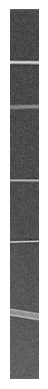

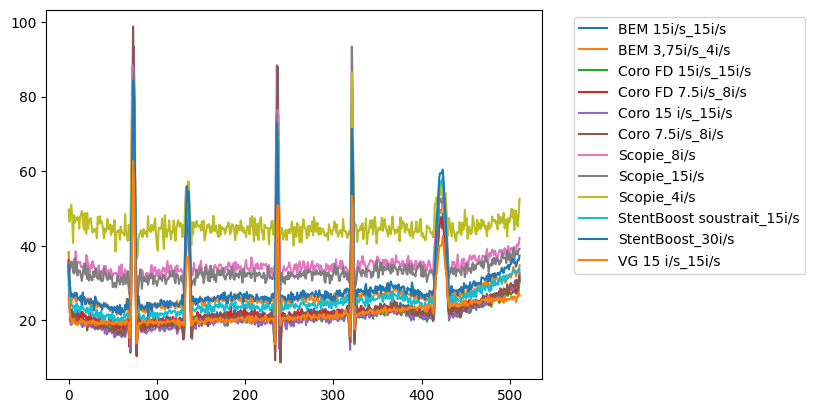

In [3]:
profils, parametres=profil(files)

[ 74 136 236 321 424]
[ 73 136 237 321 424]
[ 74 136 236 321 421]
[ 73 134 237 321 423]
[ 74 135 236 321 424]
[ 73 136 237 321 424]
[ 72 136 237 321 423]
[ 74 133 236 321 424]
[ 72 136 237 321 424]
[ 73 134 236 321 424]
[ 73 134 236 321 424]
[ 73 134 237 321 424]


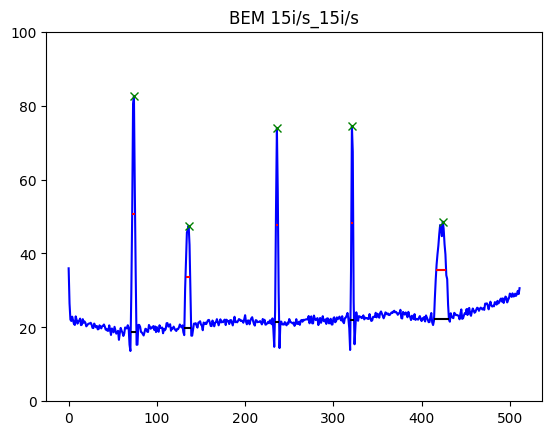

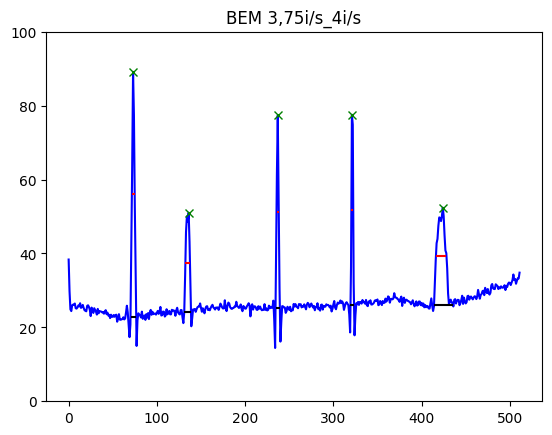

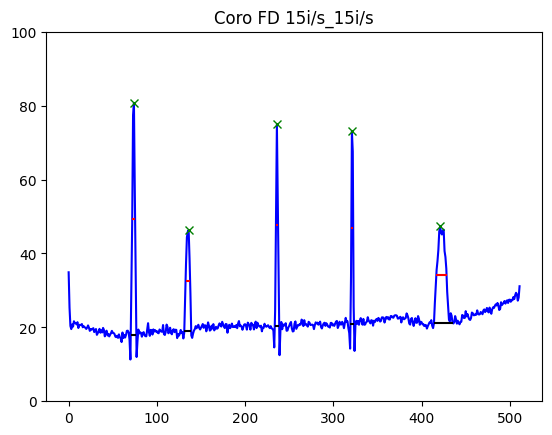

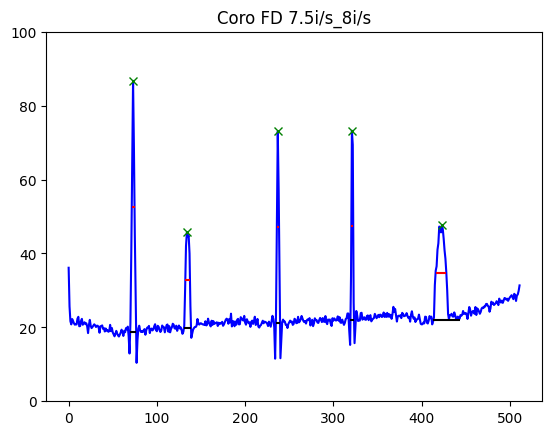

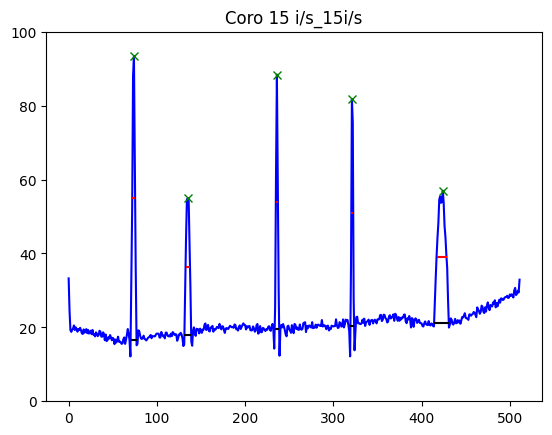

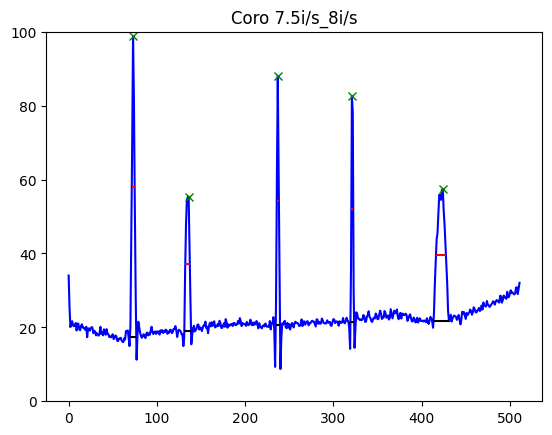

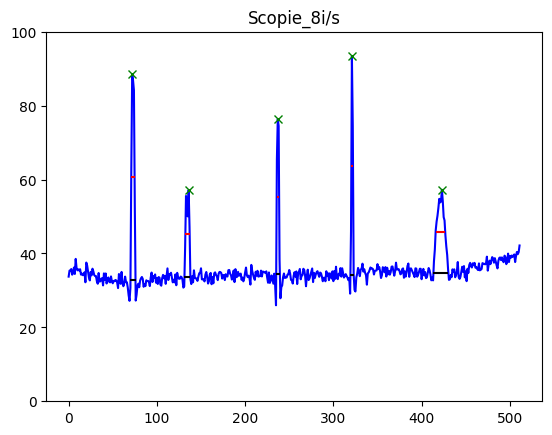

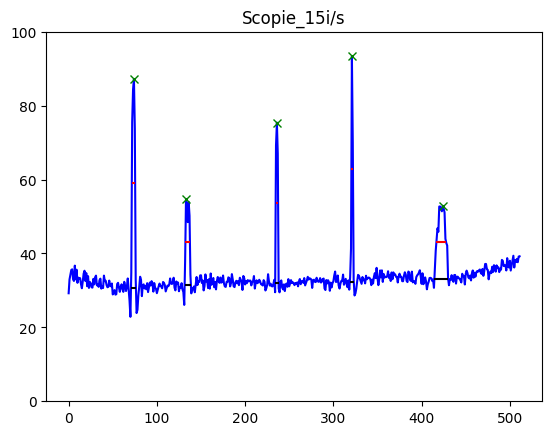

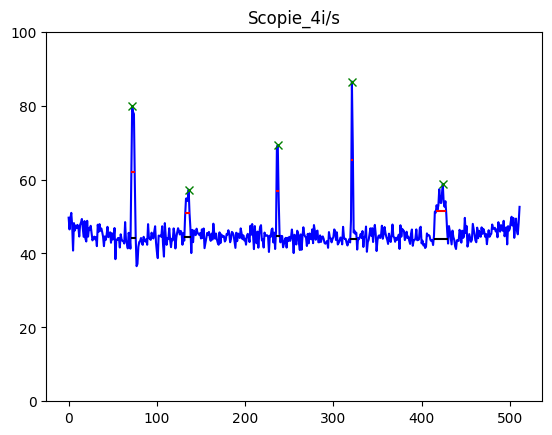

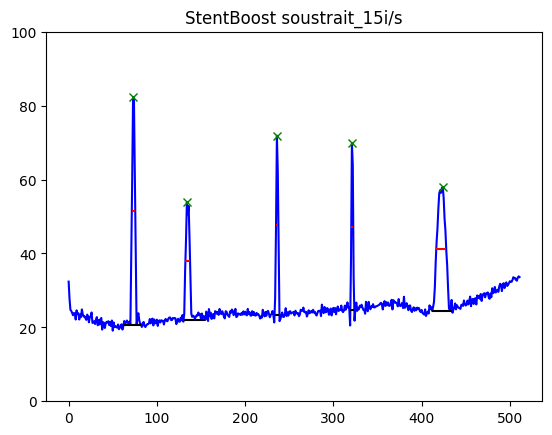

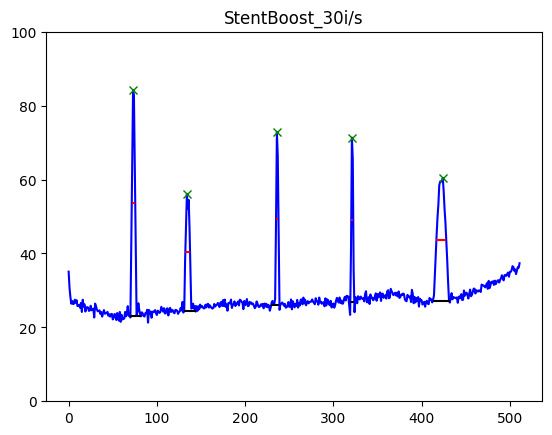

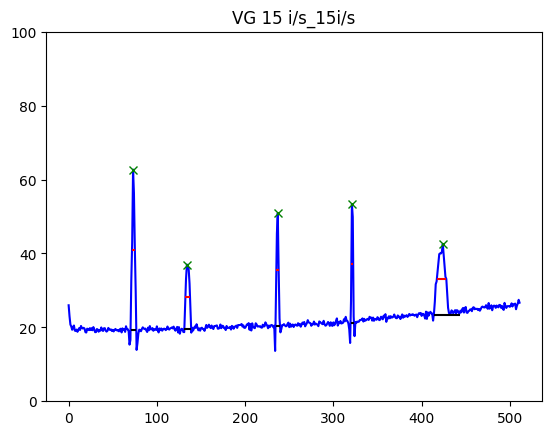

In [4]:
FWHM_data, Amplitude_data = FWHM(profils)

<Axes: >

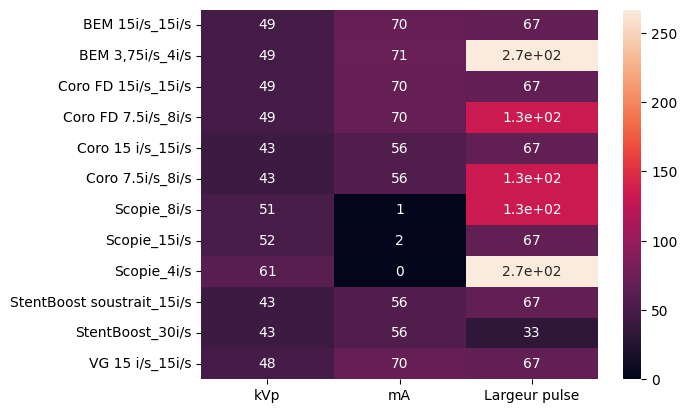

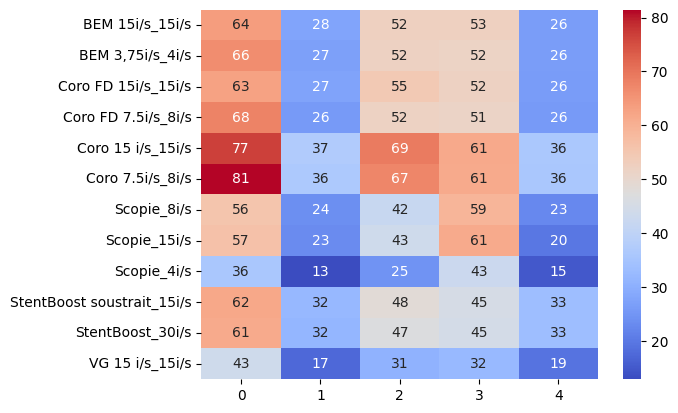

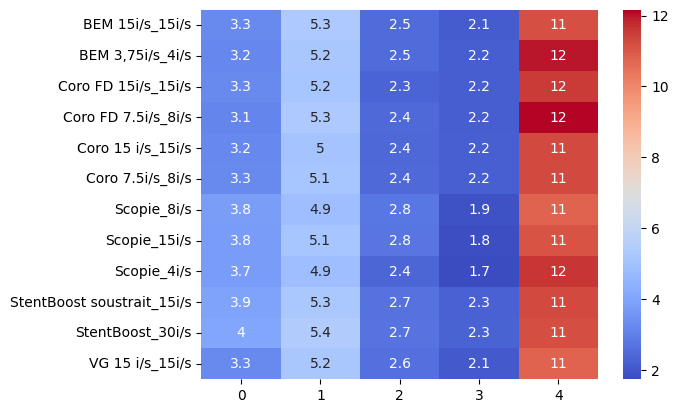

In [5]:
plt.figure()
seaborn.heatmap(parametres.T, annot=True)

plt.figure()
seaborn.heatmap(Amplitude_data.T, annot=True, cmap="coolwarm")

plt.figure()
seaborn.heatmap(FWHM_data.T, annot=True, cmap="coolwarm")